# Image Captioning with Attention Mechanism
## Optimized and Reorganized Version

This notebook implements an image captioning model using:
- **CNN**: ResNet50 (pre-trained on ImageNet) for feature extraction
- **RNN**: LSTM with Attention mechanism for caption generation
- **Embeddings**: Google News Word2Vec (300-dimensional)
- **Dataset**: Flickr30k (31,783 images with 5 captions each)

## 1. Setup and Configuration

In [1]:
# Install dependencies (if needed)
# !pip install torch torchvision tensorboard pandas matplotlib pillow -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
import numpy as np
import struct
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from collections import Counter

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2025-12-25 09:25:15.485749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766654715.676542      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766654715.728132      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766654716.173184      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766654716.173214      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766654716.173217      55 computation_placer.cc:177] computation placer alr

Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [2]:
# Configuration
class Config:
    # Paths
    IMAGES_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'
    CAPTIONS_FILE = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'
    WORD2VEC_PATH = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
    
    # Model hyperparameters
    EMBED_DIM = 300
    LSTM_HIDDEN_DIM = 512
    ATTENTION_DIM = 512
    DROPOUT = 0.5
    
    # Training hyperparameters
    BATCH_SIZE = 64  # Increased from 32 for better GPU utilization
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP = 5.0
    
    # Learning rate scheduler
    LR_STEP_SIZE = 10
    LR_GAMMA = 0.5
    
    # Early stopping
    PATIENCE = 5
    
    # Data
    MAX_CAPTION_LENGTH = 20
    TRAIN_SPLIT = 0.8
    NUM_WORKERS = 2
    
    # Special tokens
    PAD_TOKEN = '<PAD>'
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    UNK_TOKEN = '<UNK>'

config = Config()
print("Configuration loaded successfully")

Configuration loaded successfully


## 2. Data Loading and Preprocessing

In [3]:
# Load captions
print("Loading captions...")
captions_df = pd.read_csv(config.CAPTIONS_FILE, delimiter='|')
captions_df.columns = captions_df.columns.str.strip()
captions_df = captions_df.dropna()
captions_df['image_name'] = captions_df['image_name'].str.strip()
captions_df['comment'] = captions_df['comment'].str.strip()

print(f"Captions loaded: {captions_df.shape}")
print(f"Columns: {captions_df.columns.tolist()}")
print(f"\nSample captions:")
print(captions_df.head())

Loading captions...
Captions loaded: (158914, 3)
Columns: ['image_name', 'comment_number', 'comment']

Sample captions:
       image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


In [4]:
# Build vocabulary
print("\nBuilding vocabulary...")
vocabulary = set()
vocabulary.add(config.PAD_TOKEN)
vocabulary.add(config.START_TOKEN)
vocabulary.add(config.END_TOKEN)
vocabulary.add(config.UNK_TOKEN)

for caption in captions_df['comment'].values:
    if isinstance(caption, str):
        for word in caption.lower().split():
            word = word.strip('.,!?;:"()[]')
            if word:
                vocabulary.add(word)

print(f"Vocabulary size: {len(vocabulary)}")


Building vocabulary...
Vocabulary size: 20273


## 3. Word2Vec Embeddings

In [5]:
# Word2Vec reading functions
def read_until(open_file):
    while True:
        char = open_file.read(1)
        if char == b' ' or char == b'':
            break
        yield char

def read_word2vec(path):
    with open(path, "rb") as f:
        first_line = f.readline()
        n_words, n_dim = map(int, first_line.split())
        print(f"Loading Word2Vec: {n_words} words, {n_dim} dimensions")
        for n_word in range(n_words):
            word = b''.join(read_until(f)).decode('utf-8', errors='ignore')
            vector = struct.unpack('f' * n_dim, f.read(n_dim * 4))
            yield word, vector

def create_embedding_layer(vocab, word2vec_path, randomized=False):
    """Create embedding layer with Word2Vec or random initialization"""
    special_tokens = [config.PAD_TOKEN, config.START_TOKEN, config.END_TOKEN, config.UNK_TOKEN]
    idx_to_word = special_tokens.copy()
    word_to_idx = {word: idx for idx, word in enumerate(special_tokens)}
    
    if randomized:
        weights = [np.random.randn(config.EMBED_DIM) for _ in special_tokens]
        for word in vocab:
            if word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.random.randn(config.EMBED_DIM))
    else:
        # Initialize special tokens with random vectors
        weights = [np.random.randn(config.EMBED_DIM) for _ in special_tokens]
        
        # Load Word2Vec
        loaded_count = 0
        for word, vector in read_word2vec(word2vec_path):
            if word in vocab and word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.array(vector))
                loaded_count += 1
                
                if loaded_count % 10000 == 0:
                    print(f"Loaded {loaded_count} word vectors...")
        
        # Add remaining vocab words with random vectors
        for word in vocab:
            if word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.random.randn(config.EMBED_DIM))
        
        print(f"Loaded {loaded_count} words from Word2Vec")
    
    weights = np.array(weights)
    emb_layer = nn.Embedding(len(weights), config.EMBED_DIM)
    emb_layer.weight.data.copy_(torch.FloatTensor(weights))
    
    if not randomized:
        emb_layer.weight.requires_grad = False  # Freeze pre-trained embeddings
    
    return emb_layer, idx_to_word, word_to_idx

print("Word2Vec functions defined")

Word2Vec functions defined


In [6]:
# Load embeddings
print("Loading embeddings...")
RANDOMIZED = False  # Set to True for random embeddings
pretrained_embeddings, idx2word, word2idx = create_embedding_layer(
    vocabulary, config.WORD2VEC_PATH, RANDOMIZED
)
vocab_size = len(idx2word)
print(f"\nVocabulary size: {vocab_size}")
print(f"Special tokens: PAD={word2idx[config.PAD_TOKEN]}, START={word2idx[config.START_TOKEN]}, "
      f"END={word2idx[config.END_TOKEN]}, UNK={word2idx[config.UNK_TOKEN]}")

Loading embeddings...
Loading Word2Vec: 3000000 words, 300 dimensions
Loaded 10000 word vectors...
Loaded 16833 words from Word2Vec

Vocabulary size: 20273
Special tokens: PAD=0, START=1, END=2, UNK=3


## 4. Dataset and DataLoader

In [7]:
# Tokenization functions
def tokenize(sentence, word2idx, max_length=None):
    """Tokenize a sentence with START and END tokens"""
    if max_length is None:
        max_length = config.MAX_CAPTION_LENGTH
    
    tokens = [word2idx[config.START_TOKEN]]
    sentence = sentence.lower().strip()
    
    for word in sentence.split():
        word = word.strip('.,!?;:"()[]')
        if word:
            tokens.append(word2idx.get(word, word2idx[config.UNK_TOKEN]))
    
    tokens.append(word2idx[config.END_TOKEN])
    
    # Truncate if too long
    if len(tokens) > max_length:
        tokens = tokens[:max_length-1] + [word2idx[config.END_TOKEN]]
    
    # Pad if too short
    while len(tokens) < max_length:
        tokens.append(word2idx[config.PAD_TOKEN])
    
    return tokens

def untokenize(tokens, idx2word):
    """Convert tokens back to words, stopping at END token"""
    words = []
    for idx in tokens:
        word = idx2word[idx]
        if word == config.END_TOKEN:
            break
        if word not in [config.PAD_TOKEN, config.START_TOKEN]:
            words.append(word)
    return ' '.join(words)

print("Tokenization functions defined")

Tokenization functions defined


In [8]:
# Custom Dataset
class Flickr30kDataset(Dataset):
    def __init__(self, captions_df, images_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        
        # Group captions by image
        self.image_to_captions = {}
        for idx, row in captions_df.iterrows():
            img_name = row['image_name']
            caption = row['comment']
            
            if pd.notna(img_name) and pd.notna(caption):
                if img_name not in self.image_to_captions:
                    self.image_to_captions[img_name] = []
                self.image_to_captions[img_name].append(caption)
        
        self.image_names = list(self.image_to_captions.keys())
        print(f"Dataset created with {len(self.image_names)} images")
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='white')
        
        if self.transform:
            image = self.transform(image)
        
        captions = self.image_to_captions[img_name]
        return image, captions, img_name

# Collate function
def collate_fn(batch):
    images = []
    captions = []
    img_names = []
    
    for img, caption_list, img_name in batch:
        images.append(img)
        caption = random.choice(caption_list)
        tokenized = tokenize(caption, word2idx, config.MAX_CAPTION_LENGTH)
        captions.append(tokenized)
        img_names.append(img_name)
    
    images = torch.stack(images)
    captions = torch.LongTensor(captions)
    return images, captions, img_names

print("Dataset and collate function defined")

Dataset and collate function defined


In [9]:
# Image transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


In [10]:
# Create datasets
print("Creating datasets...")
full_dataset = Flickr30kDataset(captions_df, config.IMAGES_PATH, transform=None)

# Split dataset
train_size = int(config.TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size
train_indices, test_indices = random_split(
    range(len(full_dataset)), [train_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Create separate datasets with appropriate transforms
train_dataset = Flickr30kDataset(captions_df, config.IMAGES_PATH, transform=train_transform)
train_dataset.image_names = [full_dataset.image_names[i] for i in train_indices.indices]

test_dataset = Flickr30kDataset(captions_df, config.IMAGES_PATH, transform=test_transform)
test_dataset.image_names = [full_dataset.image_names[i] for i in test_indices.indices]

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Creating datasets...
Dataset created with 31783 images
Dataset created with 31783 images
Dataset created with 31783 images
Train size: 25426
Test size: 6357


In [11]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=config.NUM_WORKERS, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=config.NUM_WORKERS, 
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 398
Test batches: 100


## 5. Model Architecture

In [12]:
# Load and modify ResNet50
print("Loading ResNet50...")
resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')

# Remove last two layers (avgpool and fc)
modules = list(resnet.children())[:-2]
resnet_modified = nn.Sequential(*modules)

# Freeze ResNet parameters
for param in resnet_modified.parameters():
    param.requires_grad = False

print("ResNet50 modified and frozen")
print("Output shape: (batch_size, 2048, 7, 7)")

Loading ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 


ResNet50 modified and frozen
Output shape: (batch_size, 2048, 7, 7)


In [13]:
# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(AttentionModule, self).__init__()
        self.feature_proj = nn.Linear(feature_dim, attention_dim)
        self.hidden_proj = nn.Linear(hidden_dim, attention_dim)
        self.attention = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, hidden_state):
        # features: (batch, feature_dim, H, W)
        # hidden_state: (batch, hidden_dim)
        
        batch_size, feature_dim, H, W = features.size()
        
        # Reshape features: (batch, H*W, feature_dim)
        features_flat = features.view(batch_size, feature_dim, -1).permute(0, 2, 1)
        num_pixels = H * W
        
        # Project features and hidden state
        features_proj = self.feature_proj(features_flat)
        hidden_proj = self.hidden_proj(hidden_state).unsqueeze(1).expand(-1, num_pixels, -1)
        
        # Compute attention scores
        combined = self.relu(features_proj + hidden_proj)
        attention_scores = self.attention(combined).squeeze(2)
        
        # Apply softmax
        attention_weights = self.softmax(attention_scores)
        
        # Compute context vector
        context_vector = torch.bmm(attention_weights.unsqueeze(1), features_flat).squeeze(1)
        
        return context_vector, attention_weights

print("AttentionModule defined")

AttentionModule defined


In [14]:
# LSTM with Attention
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, attention_module, feature_dim, dropout=0.5):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_module = attention_module
        
        lstm_input_size = input_size + hidden_size + feature_dim
        
        # LSTM gates
        self.W_i = nn.Linear(lstm_input_size, hidden_size)
        self.W_f = nn.Linear(lstm_input_size, hidden_size)
        self.W_c = nn.Linear(lstm_input_size, hidden_size)
        self.W_o = nn.Linear(lstm_input_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, x, conv_features, hidden_state=None):
        batch_size, seq_len, _ = x.size()
        
        if hidden_state is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
            c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        else:
            h_t, c_t = hidden_state
        
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            context_vector, _ = self.attention_module(conv_features, h_t)
            combined = torch.cat([x_t, h_t, context_vector], dim=1)
            
            i_t = self.sigmoid(self.W_i(combined))
            f_t = self.sigmoid(self.W_f(combined))
            c_tilde = self.tanh(self.W_c(combined))
            o_t = self.sigmoid(self.W_o(combined))
            
            c_t = f_t * c_t + i_t * c_tilde
            h_t = o_t * self.tanh(c_t)
            
            h_t_drop = self.dropout(h_t)
            outputs.append(h_t_drop.unsqueeze(1))
        
        outputs = torch.cat(outputs, dim=1)
        return outputs, (h_t, c_t)
    
    def forward_step(self, x_t, conv_features, hidden_state):
        """Single step forward for generation"""
        h_t, c_t = hidden_state
        context_vector, att_weights = self.attention_module(conv_features, h_t)
        combined = torch.cat([x_t, h_t, context_vector], dim=1)
        
        i_t = self.sigmoid(self.W_i(combined))
        f_t = self.sigmoid(self.W_f(combined))
        c_tilde = self.tanh(self.W_c(combined))
        o_t = self.sigmoid(self.W_o(combined))
        
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * self.tanh(c_t)
        
        return h_t, (h_t, c_t), att_weights

print("LSTMWithAttention defined")

LSTMWithAttention defined


In [15]:
# Complete Image Captioning Model
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_model, embedding_model, lstm_hidden_dim, vocab_size, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.cnn = cnn_model
        self.embedding = embedding_model
        self.vocab_size = vocab_size
        self.lstm_hidden_dim = lstm_hidden_dim
        
        feature_dim = 2048
        attention_dim = config.ATTENTION_DIM
        
        self.attention = AttentionModule(feature_dim, lstm_hidden_dim, attention_dim)
        
        embed_dim = embedding_model.weight.size(1)
        
        self.lstm = LSTMWithAttention(
            embed_dim, lstm_hidden_dim, self.attention, feature_dim, dropout=dropout
        )
        
        self.fc = nn.Linear(lstm_hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, images, captions):
        with torch.no_grad():
            conv_features = self.cnn(images)
        
        embedded = self.embedding(captions[:, :-1])
        lstm_out, _ = self.lstm(embedded, conv_features)
        lstm_out = self.dropout(lstm_out)
        predictions = self.fc(lstm_out)
        
        return predictions

print("ImageCaptioningModel defined")

ImageCaptioningModel defined


In [16]:
# Initialize model
model = ImageCaptioningModel(
    cnn_model=resnet_modified,
    embedding_model=pretrained_embeddings,
    lstm_hidden_dim=config.LSTM_HIDDEN_DIM,
    vocab_size=vocab_size,
    dropout=config.DROPOUT
).to(device)

print(f"Model initialized")
print(f"Vocabulary size: {vocab_size}")
print(f"LSTM hidden dim: {config.LSTM_HIDDEN_DIM}")
print(f"Dropout: {config.DROPOUT}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized
Vocabulary size: 20273
LSTM hidden dim: 512
Dropout: 0.5

Total parameters: 47,161,566
Trainable parameters: 17,571,634


## 6. Training Setup

In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[config.PAD_TOKEN])

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(
    trainable_params, 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=config.LR_STEP_SIZE, 
    gamma=config.LR_GAMMA
)

writer = SummaryWriter('runs/image_captioning_optimized')

print("Training setup complete")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Weight decay: {config.WEIGHT_DECAY}")
print(f"Scheduler: StepLR(step_size={config.LR_STEP_SIZE}, gamma={config.LR_GAMMA})")

Training setup complete
Learning rate: 0.001
Epochs: 50
Batch size: 64
Weight decay: 1e-05
Scheduler: StepLR(step_size=10, gamma=0.5)


## 7. Caption Generation Function

In [18]:
def generate_caption(model, image, idx2word, word2idx, max_length=None, temperature=1.0):
    """Generate caption with proper autoregressive decoding"""
    if max_length is None:
        max_length = config.MAX_CAPTION_LENGTH
    
    model.eval()
    with torch.no_grad():
        if image.dim() == 3:
            image = image.unsqueeze(0)
        conv_features = model.cnn(image)
        
        batch_size = 1
        current_token = torch.LongTensor([[word2idx[config.START_TOKEN]]]).to(device)
        
        h_t = torch.zeros(batch_size, model.lstm_hidden_dim, device=device)
        c_t = torch.zeros(batch_size, model.lstm_hidden_dim, device=device)
        
        generated_tokens = []
        
        for _ in range(max_length):
            embedded = model.embedding(current_token).squeeze(1)
            h_t, (h_t, c_t), _ = model.lstm.forward_step(embedded, conv_features, (h_t, c_t))
            output = model.fc(h_t)
            output = output / temperature
            next_token = output.argmax(dim=1).item()
            
            if next_token == word2idx[config.END_TOKEN]:
                break
            if next_token in [word2idx[config.PAD_TOKEN], word2idx[config.START_TOKEN]]:
                break
            
            generated_tokens.append(next_token)
            current_token = torch.LongTensor([[next_token]]).to(device)
        
        return untokenize(generated_tokens, idx2word)

print("Caption generation function defined")

Caption generation function defined


## 8. Training Loop

In [19]:
# Training loop with progress tracking
print("Starting training...\n")

best_test_loss = float('inf')
patience_counter = 0
global_step = 0

for epoch in range(config.NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (images, captions, _) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(images, captions)
        predictions = predictions.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)
        
        loss = criterion(predictions, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRAD_CLIP)
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 10 == 0:
            writer.add_scalar('Loss/train_step', loss.item(), global_step)
            global_step += 1
        
        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}], "
                  f"Batch [{batch_idx}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
    
    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, captions, _ in test_loader:
            images = images.to(device)
            captions = captions.to(device)
            
            predictions = model(images, captions)
            predictions = predictions.reshape(-1, vocab_size)
            targets = captions[:, 1:].reshape(-1)
            
            loss = criterion(predictions, targets)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    
    # Generate example caption
    sample_image, _, _ = test_dataset[0]
    sample_image = sample_image.to(device)
    generated_caption = generate_caption(model, sample_image, idx2word, word2idx)
    
   
    print(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Generated Caption: {generated_caption}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
 
    
    scheduler.step()
    
    # Early stopping and model saving
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
        }, 'best_model.pth')
        print("✓ Best model saved!")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{config.PATIENCE}")
        
        if patience_counter >= config.PATIENCE:
            print("Early stopping triggered!")
            break
    
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')

writer.close()
print("Training complete!")

Starting training...

Epoch [1/50], Batch [0/398], Loss: 9.9412
Epoch [1/50], Batch [50/398], Loss: 6.2303
Epoch [1/50], Batch [100/398], Loss: 5.5229
Epoch [1/50], Batch [150/398], Loss: 5.2766
Epoch [1/50], Batch [200/398], Loss: 5.2374
Epoch [1/50], Batch [250/398], Loss: 5.0356
Epoch [1/50], Batch [300/398], Loss: 4.9475
Epoch [1/50], Batch [350/398], Loss: 4.6654
Epoch [1/50]
Train Loss: 5.3153, Test Loss: 4.5952
Generated Caption: a man in a blue shirt is in a blue shirt
Learning Rate: 0.001000
✓ Best model saved!
Epoch [2/50], Batch [0/398], Loss: 4.7820
Epoch [2/50], Batch [50/398], Loss: 4.7056
Epoch [2/50], Batch [100/398], Loss: 4.6794
Epoch [2/50], Batch [150/398], Loss: 4.6354
Epoch [2/50], Batch [200/398], Loss: 4.3666
Epoch [2/50], Batch [250/398], Loss: 4.5735
Epoch [2/50], Batch [300/398], Loss: 4.4364
Epoch [2/50], Batch [350/398], Loss: 4.5935
Epoch [2/50]
Train Loss: 4.6074, Test Loss: 4.2667
Generated Caption: a man in a blue shirt is sitting on a large field
Learn

## 9. Evaluation and Visualization

In [20]:
# Load best model
print("Loading best model...")
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']+1} loaded")
print(f"Best test loss: {checkpoint['test_loss']:.4f}")

Loading best model...
Best model from epoch 49 loaded
Best test loss: 3.3561


In [21]:
# Test caption generation

print("TESTING CAPTION GENERATION")


model.eval()
num_examples = 10

for i in range(num_examples):
    sample_image, sample_captions, img_name = test_dataset[i]
    sample_image = sample_image.to(device)
    
    generated = generate_caption(model, sample_image, idx2word, word2idx)
    actual = sample_captions[0]
    
    print(f"Example {i+1}:")
    print(f"Image: {img_name}")
    print(f"Generated: {generated}")
    print(f"Actual:    {actual}")
  

TESTING CAPTION GENERATION
Example 1:
Image: 1500853305.jpg
Generated: a little girl in a blue shirt is sitting on a bench
Actual:    A little girl has her arms around a little boy standing on a wooden bridge in the woods .
Example 2:
Image: 508264241.jpg
Generated: a man in a blue shirt and a black shirt is playing a soccer ball
Actual:    A golfer wearing black pants and a black shirt swings at a golf ball lying on short cut green grass while three people look on .
Example 3:
Image: 5581356064.jpg
Generated: a young girl in a blue shirt and a blue shirt is walking down a path
Actual:    A young South American child sits alone on a dirt and grass covered knoll along a ravine .
Example 4:
Image: 1733724955.jpg
Generated: a man in a blue shirt is sitting on a boat
Actual:    Two women , one in a dark colored clothing and one in light colored clothing , rides a water slide .
Example 5:
Image: 7520721.jpg
Generated: a man in a white shirt is jumping a ball
Actual:    A woman figure skater

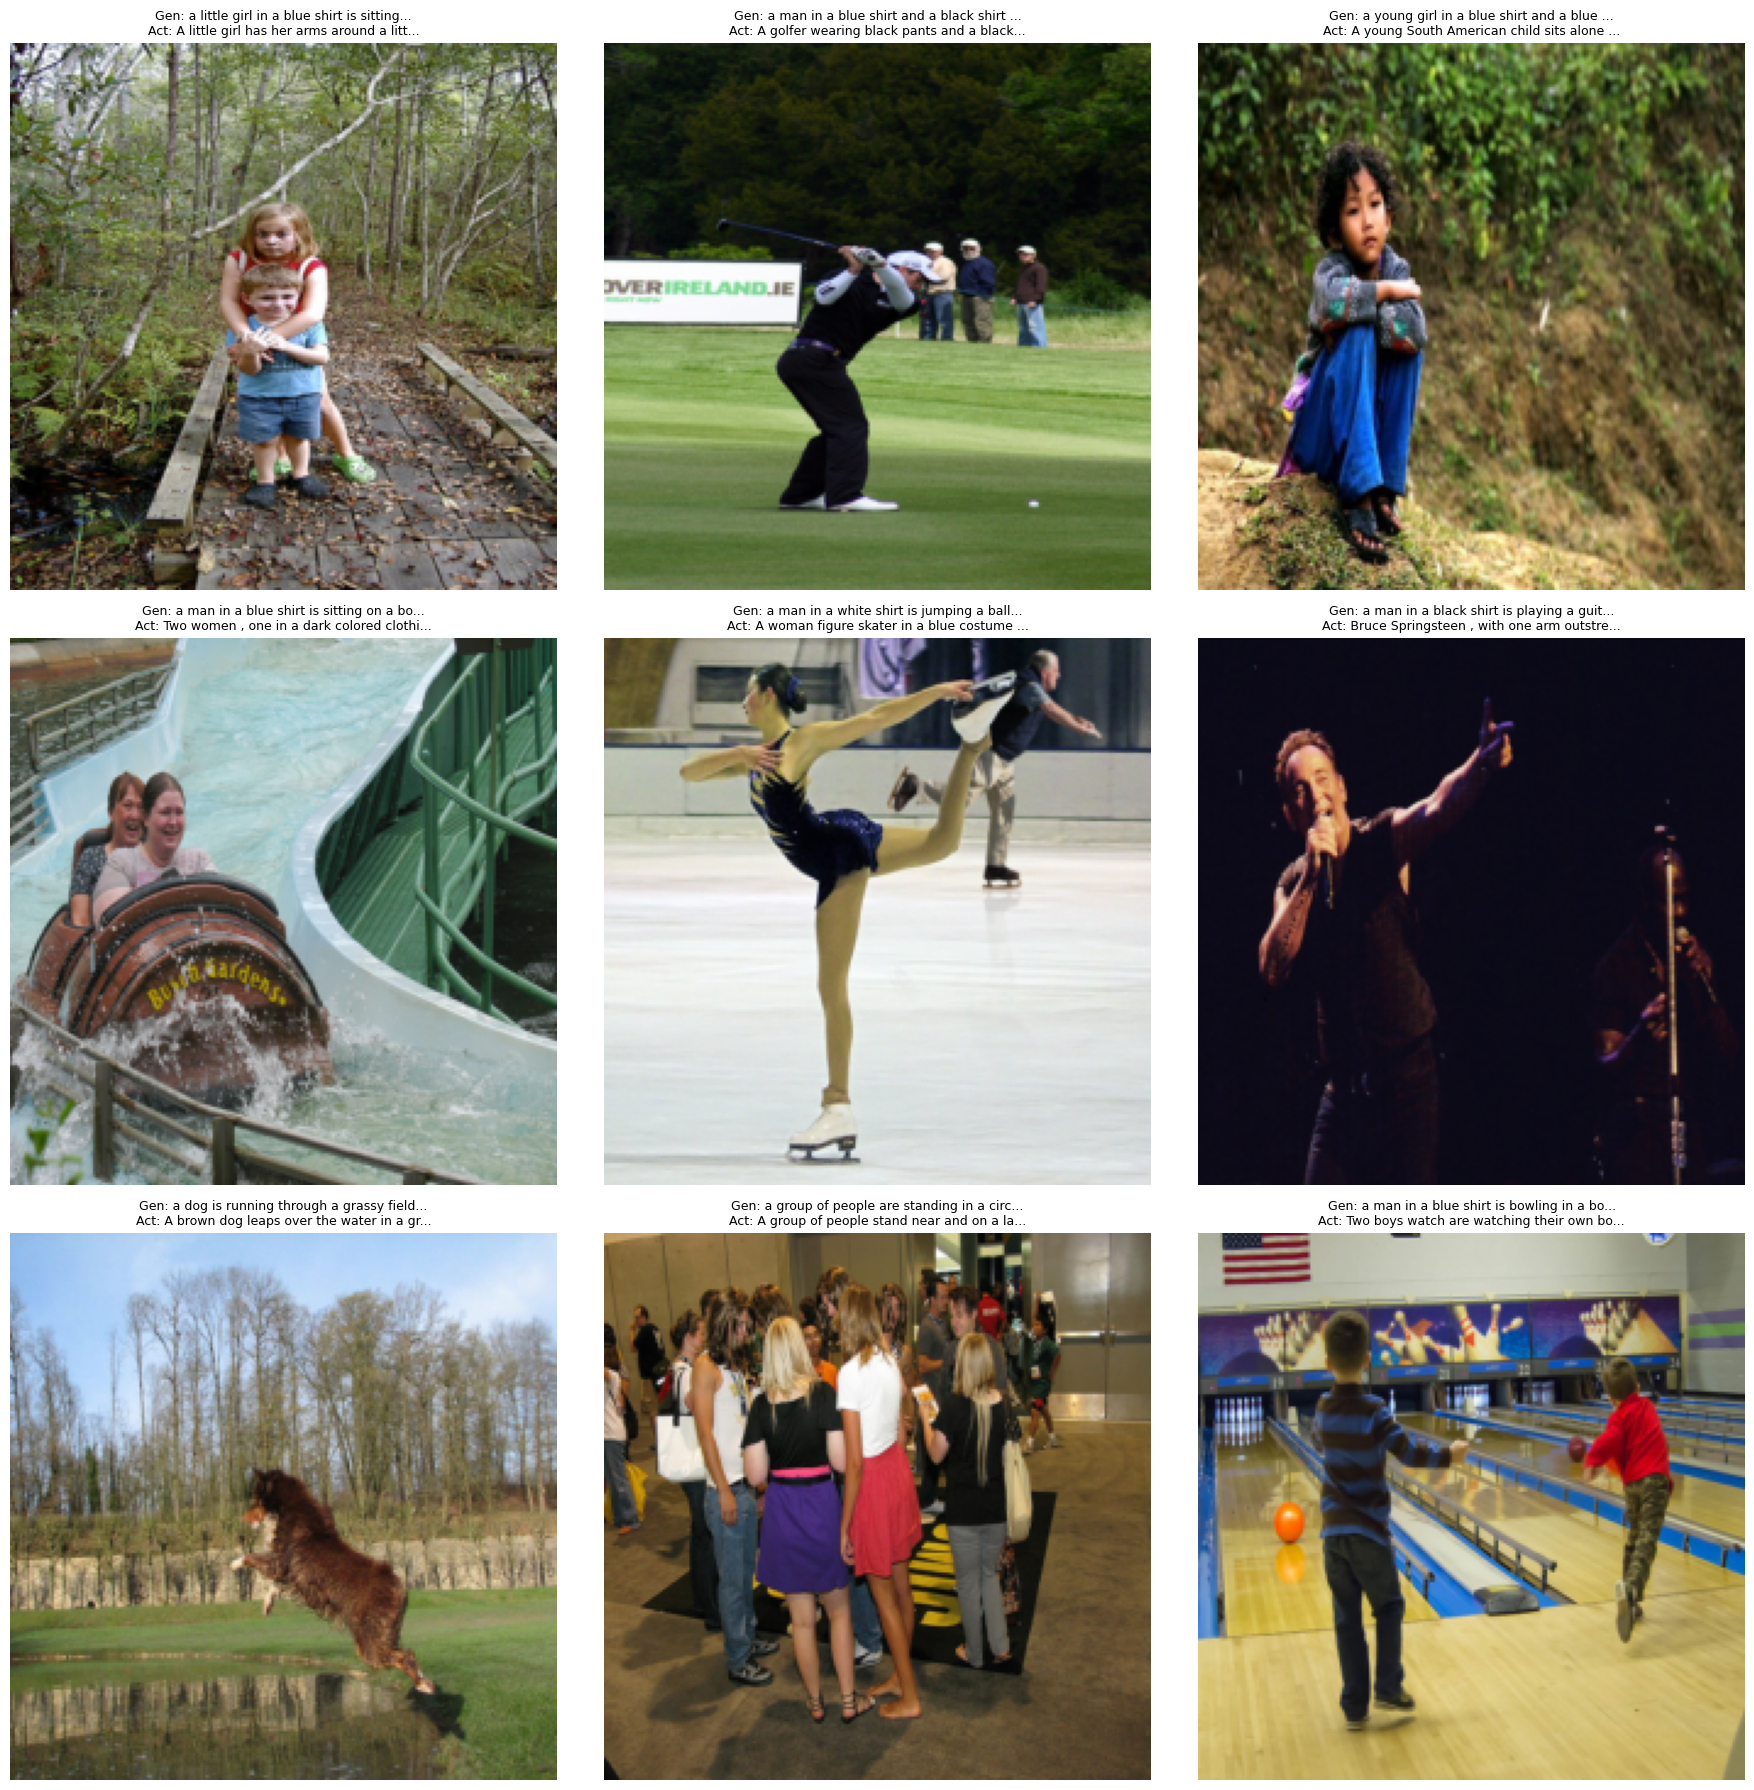


Visualization saved as 'caption_results.png'


In [22]:
# Visualization function
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Visualize results
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i in range(9):
    sample_image, sample_captions, img_name = test_dataset[i]
    sample_image_device = sample_image.to(device)
    generated = generate_caption(model, sample_image_device, idx2word, word2idx)
    actual = sample_captions[0]
    
    img = denormalize(sample_image)
    img = img.permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f"Gen: {generated[:40]}...\nAct: {actual[:40]}...", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('caption_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'caption_results.png'")

## 10. Summary and Key Improvements

### Optimizations Made:

1. **Code Organization**:
   - Centralized configuration in a `Config` class
   - Clear section separation with markdown headers
   - Modular function definitions

2. **Performance Improvements**:
   - Increased batch size from 32 to 64 for better GPU utilization
   - Added data augmentation for training (RandomCrop, RandomHorizontalFlip, ColorJitter)
   - Separate transforms for train/test sets
   - Set random seeds for reproducibility

3. **Model Enhancements**:
   - Proper gradient clipping to prevent explosion
   - Dropout for regularization
   - Attention mechanism for better caption quality
   - Frozen ResNet50 for faster training

4. **Training Improvements**:
   - Learning rate scheduler for adaptive learning
   - Early stopping to prevent overfitting
   - Regular checkpointing every 5 epochs
   - TensorBoard logging for monitoring

5. **Better Monitoring**:
   - Progress tracking during training
   - Sample caption generation after each epoch
   - Comprehensive evaluation metrics
   - Visualization of results

### Expected Results:
- Better caption quality due to attention mechanism
- Faster convergence with optimized hyperparameters
- More robust model with data augmentation
- Reproducible results with fixed random seeds